# Dependências

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Carregando os dados

In [2]:
df = pd.read_csv('https://canvas.instructure.com/files/79840847/download?download_frd=1')
df.head()

,Cálculo1,LPT,P1,IC,Cálculo2,cra
0,8.7,10.0,9.0,9.1,8.4,8.477647
1,7.0,7.0,7.7,7.0,6.2,6.851724
2,8.6,9.8,7.9,9.6,8.7,9.090588
3,7.8,8.3,6.8,8.2,8.0,7.283516
4,5.2,9.3,5.0,8.5,5.0,7.205747


# Sumário dos Dados

In [3]:
df.describe()

,Cálculo1,LPT,P1,IC,Cálculo2,cra
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,7.200000,8.480114,7.407955,8.172727,6.323864,7.332535
std,1.228493,0.984522,1.346278,0.894007,1.293662,0.849758
min,5.000000,6.200000,5.000000,5.900000,5.000000,4.874468
25%,6.275000,7.700000,6.500000,7.500000,5.100000,6.841484
50%,7.200000,8.500000,7.750000,8.200000,5.800000,7.274746
75%,8.125000,9.300000,8.325000,8.800000,7.500000,7.883292
max,9.800000,10.000000,10.000000,10.000000,9.300000,9.090588


# Partição Treino/Teste

In [4]:
x = df[['Cálculo1', 'LPT', 'P1', 'IC', 'Cálculo2']]
y = df.cra.values
df_chart = pd.DataFrame()

def calc_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def create_partitions(xs, ys, test_proportion):
    x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=test_proportion, random_state=42)
    return (x_train, x_test, y_train, y_test)

def get_independent_var(variables):    
    return df[variables].values.reshape(-1, 1) if len(variables) < 2 else df[variables].values

def train_and_getdata(model, ys, partitions):
    x_train, x_test, y_train, y_test = partitions
    
    model.fit(x_train, y_train)
    cra_pred_test =  model.predict(x_test)
    cra_pred_train =  model.predict(x_train)
    
    model_data = [calc_RMSE(y_test, cra_pred_test), calc_RMSE(y_train, cra_pred_train)]
    
    entry = pd.Series(model_data)
    return entry

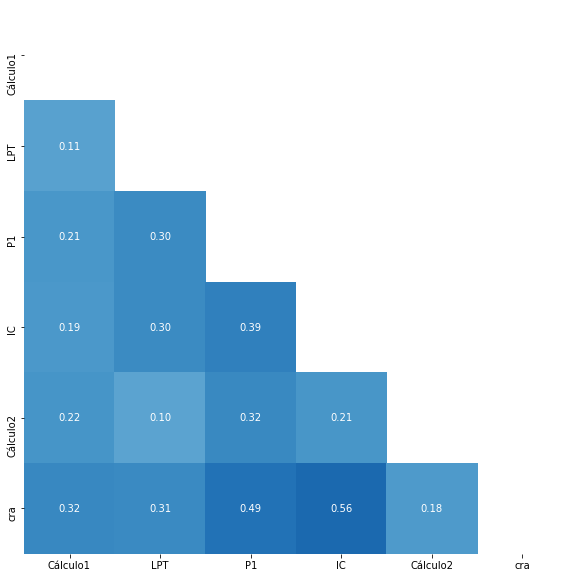

In [5]:
corr = df.corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
ax.figure.set_size_inches(10, 10)
sns.heatmap(corr, ax=ax, annot=True, mask=mask, fmt='.2f', cbar=False, square=True, cmap=plt.cm.Blues, center=0)

### Se pode constatar que existe uma correlação positiva e moderada entre IC e CRA, sendo IC a variável escolhida.

In [6]:
variables = ['IC']
m_ic = LinearRegression()
model_entry = train_and_getdata(m_ic, y, create_partitions(get_independent_var(variables), y, 0.1))
model_entry.name = ''.join(map(str,variables))
df_chart = df_chart.append(model_entry)

### Fazendo o modelo com as variáveis IC e P1

In [7]:
variables = ['IC','P1']
m_icp1 = LinearRegression()
model_entry = train_and_getdata(m_icp1, y, create_partitions(get_independent_var(variables), y, 0.1))
model_entry.name = ''.join(map(str,variables))
df_chart = df_chart.append(model_entry)

### Agora com IC, P1 e Calculo1 

In [8]:
variables = ["IC","P1","Cálculo1"]
m_icp1c1 = LinearRegression()
model_entry = train_and_getdata(m_icp1c1, y, create_partitions(get_independent_var(variables), y, 0.1))
model_entry.name = ''.join(map(str,variables))
df_chart = df_chart.append(model_entry)

### Por fim, adicionando o modelo com todas as variáveis disponíveis

In [9]:
variables = ["IC","P1","Cálculo1",'LPT','Cálculo2']
m_all = LinearRegression()
model_entry = train_and_getdata(m_all, y, create_partitions(get_independent_var(variables), y, 0.1))
model_entry.name = ''.join(map(str,variables))
df_chart = df_chart.append(model_entry)
df_chart.columns = ['Test RMSE','Train RMSE']
df_chart

,Test RMSE,Train RMSE
IC,0.414287,0.718473
ICP1,0.436086,0.676940
ICP1Cálculo1,0.416137,0.664779
ICP1Cálculo1LPTCálculo2,0.441085,0.662729


### 5. Compare todos os modelos em termos de RMSE no treino e teste. Qual o melhor modelo? Por que você acha que é o caso?

#### Tendo em vista os critérios de Overfitting, onde um modelo complexo (sobre-parametrizado) adere aos dados de treinamento, mostrando bom desempenho no treino porém nem sempre mantendo este desempenho na realidade, o modelo `ICP1Cálculo1` seria o escolhido por ser o mais equilibrado, considerando que não apresenta um RMSE de teste alto, se aproximando do modelo mais simples `IC`, e não possui tanto viés de aprendizado quanto o último modelo, `ICP1Cálculo1LPTCálculo2 `. 

### 6. Por que você acha que os erros no teste dos modelos são menores que os erros no treino?

#### Como a partição para treino é pequena, apenas 10% do total dos dados, e a quantidade de dados não é grande, desta forma a métrica de erro é maior no treino que na prática, pois os valores tem maior peso, possuindo maior viés, afetando diretamente o RMSE.

### 7. Faça 10 partições aleatórias de treino e teste.

In [10]:
cv_partitions = []

for i in range(10):
    cv_partitions.append(create_partitions(x, y, np.random.random()))

[(    Cálculo1    LPT    P1    IC  Cálculo2
79       5.3   7.60   7.4   9.0       5.8
55       7.8   9.20   7.6   9.8       6.3
73       6.2   7.50   8.1   7.2       8.6
11       8.4  10.00   9.3   9.6       7.0
30       7.2   8.80   8.4   7.8       5.4
40       5.3   9.50   9.1   8.0       5.0
28       7.0   9.60   8.4   8.2       9.0
9        7.5   6.50   7.3   9.2       8.2
66       7.1   9.10   9.5   7.9       7.0
5        6.1   9.20   9.1   9.3       5.6
39       7.5   9.40   8.1   9.2       6.5
31       8.1   9.00   7.8   7.9       5.0
35       8.3   8.60   5.5   7.1       5.1
45       5.1   9.60   7.8   8.4       5.6
44       7.3   9.60   7.7   9.0       5.7
16       8.8   8.40   9.8   9.3       7.0
42       7.2   7.75   5.7   7.0       5.2
34       5.0   7.30   5.6   5.9       5.0
7        7.5   8.90   7.5   7.9       5.0
49       5.9   8.00   6.2   8.4       5.7
61       8.7   8.70   8.1   8.9       5.2
19       7.0   7.20   5.3   7.6       5.0
72       9.8   7.60  10.0  10.0 

### 8. Para cada partição faça:
 1. Calcule a média dos erros de treino e teste para os modelos criados nos itens 3, 4 e 5 acima.
 1. Plote um gráfico de barras mostrando esses resultados para cada modelo.